## Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import tifffile as tiff
import pandas as pd
import cv2
import os

In [2]:
train_img_dir = "D:\Cellula Technologies\Project 2\data\data\images"
train_mask_dir = "D:\Cellula Technologies\Project 2\data\data\labels"

In [3]:
def display_image_and_mask(img_path, mask_path):
    # قراءة الصورة من tif
    image = tiff.imread(img_path)  # ممكن يكون (12, 128, 128)
    if image.shape[0] == 12:
        image = np.moveaxis(image, 0, -1)  # → (128, 128, 12)
    elif image.shape[1] == 12:
        image = np.transpose(image, (0, 2, 1))  # safety

    # نعرض أول Band فقط (كأنه channel واحد)
    image_band = image[:, :, 0]

    # قراءة الماسك
    if mask_path.endswith('.tif'):
        mask = tiff.imread(mask_path)
    else:
        mask = Image.open(mask_path).convert('L')
        mask = np.array(mask)

    # عرض الصورة والماسك
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image_band, cmap='gray')
    plt.title("Image (Band 1)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


## Visualize

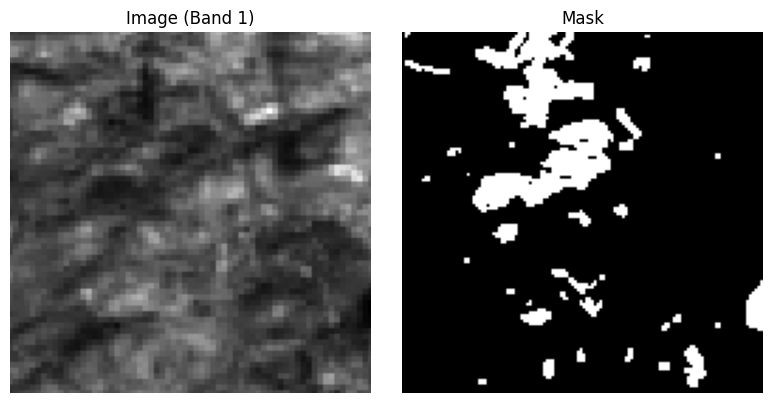

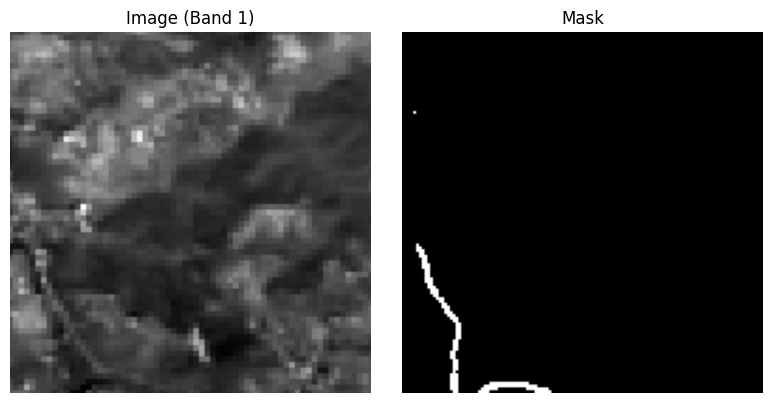

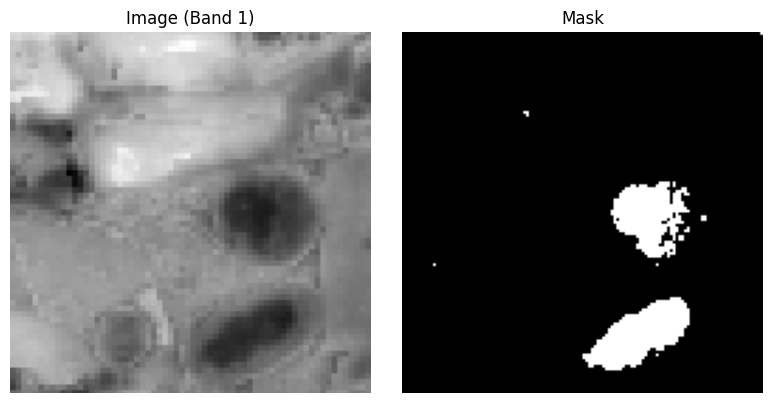

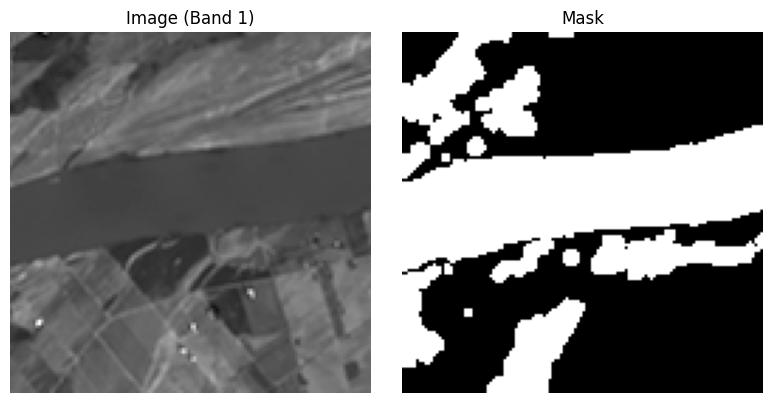

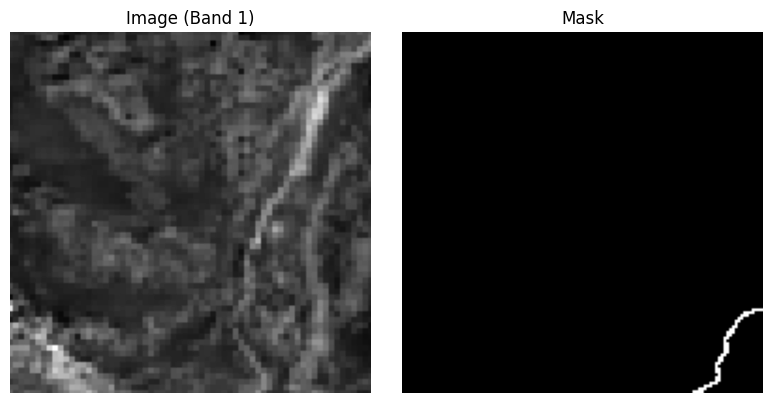

In [4]:
train_img_files = sorted(os.listdir(train_img_dir))
train_mask_files = sorted(os.listdir(train_mask_dir))

for img_file, mask_file in zip(train_img_files[:5], train_mask_files[:5]):
    img_path = os.path.join(train_img_dir, img_file)
    mask_path = os.path.join(train_mask_dir, mask_file)
    display_image_and_mask(img_path, mask_path)


In [5]:
def display_rgb_image_and_mask(img_path, mask_path, rgb_indices=[3, 2, 1]):
    # قراءة الصورة متعددة القنوات
    image = tiff.imread(img_path)
    if image.shape[0] == 12:
        image = np.moveaxis(image, 0, -1)  # (128, 128, 12)
    elif image.shape[1] == 12:
        image = np.transpose(image, (0, 2, 1))

    # اختيار 3 قنوات للـ RGB
    rgb = image[:, :, rgb_indices]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-5)  # Normalize

    # قراءة الماسك
    if mask_path.endswith('.tif'):
        mask = tiff.imread(mask_path)
    else:
        mask = Image.open(mask_path).convert('L')
        mask = np.array(mask)

    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)

    mask = (mask > 0.5).astype(np.float32)

    # العرض
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


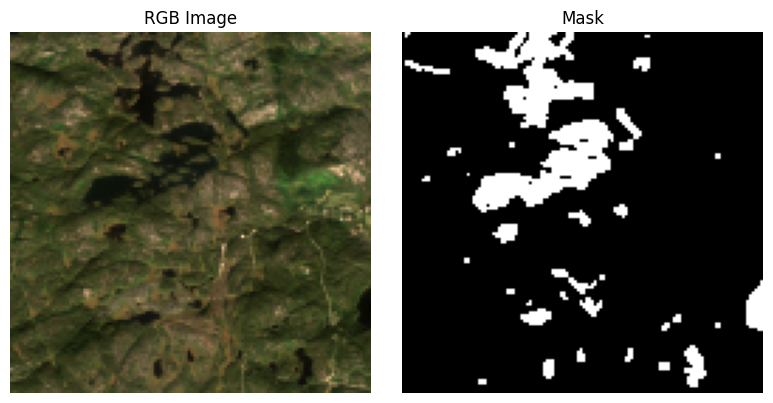

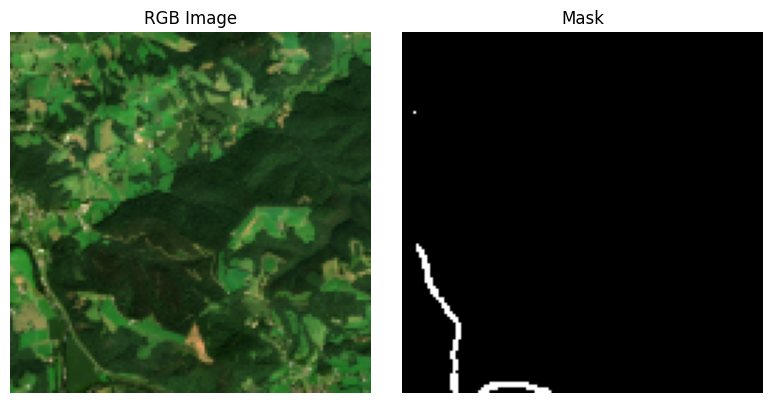

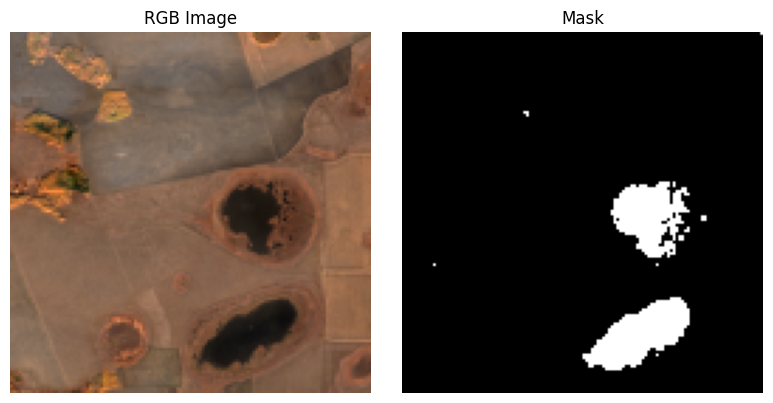

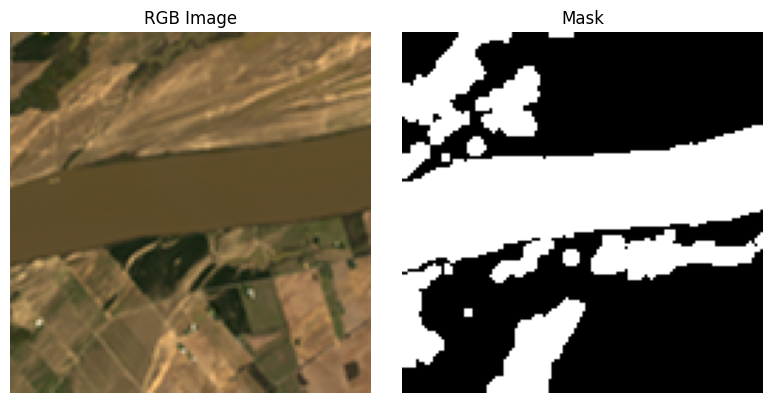

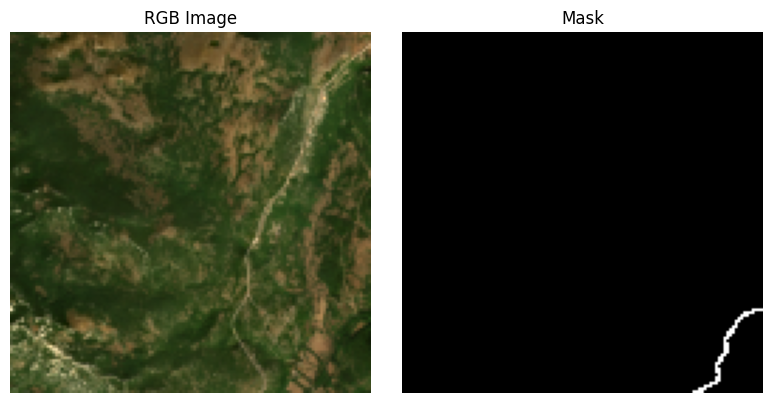

In [6]:
for img_file, mask_file in zip(train_img_files[:5], train_mask_files[:5]):
    img_path = os.path.join(train_img_dir, img_file)
    mask_path = os.path.join(train_mask_dir, mask_file)
    display_rgb_image_and_mask(img_path, mask_path)


In [7]:
images = [os.path.join(train_img_dir, file) for file in os.listdir(train_img_dir)]
masks = [os.path.join(train_mask_dir, file) for file in os.listdir(train_mask_dir)]

data = pd.DataFrame({"image": images, "mask": masks})

train_df, val_df = train_test_split(data, train_size=0.8, shuffle=True, random_state=123)

In [8]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence
import tifffile as tiff
from PIL import Image

class WaterSegmentationGenerator(Sequence):
    def __init__(self, df, batch_size=16, image_size=(128, 128), n_channels=12, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.image_size = image_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.zeros((len(batch_df), *self.image_size, self.n_channels), dtype=np.float32)
        Y = np.zeros((len(batch_df), *self.image_size, 1), dtype=np.float32)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            # --- Load image ---
            img = tiff.imread(row['image'])  # Expecting shape (12, 128, 128) or (128, 12, 128)
            if img.shape[0] == self.n_channels:
                img = np.moveaxis(img, 0, -1)
            elif img.shape[1] == self.n_channels:
                img = np.transpose(img, (0, 2, 1))
            img = img.astype(np.float32)

            # --- Apply channel-wise Min-Max Scaling ---
            for c in range(self.n_channels):
                band = img[:, :, c]
                min_val = band.min()
                max_val = band.max()
                if max_val > min_val:
                    img[:, :, c] = (band - min_val) / (max_val - min_val)
                else:
                    img[:, :, c] = 0.0

            X[i] = img

            # --- Load mask ---
            mask_path = row['mask']
            if mask_path.endswith('.tif'):
                mask = tiff.imread(mask_path)
            else:
                mask = Image.open(mask_path).convert('L')
                mask = np.array(mask)

            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)

            mask = mask.astype(np.float32)
            Y[i] = mask

        return X, Y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


## U-Net

In [9]:
def unet_model(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [10]:
model = unet_model(input_size=(128, 128, 12))


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
train_generator = WaterSegmentationGenerator(train_df, batch_size=16)
val_generator = WaterSegmentationGenerator(val_df, batch_size=16, shuffle=False)


In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  
)


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.8733 - loss: 0.3913 - val_accuracy: 0.8444 - val_loss: 0.3462
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.8779 - loss: 0.3130 - val_accuracy: 0.8705 - val_loss: 0.3121
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.8812 - loss: 0.3116 - val_accuracy: 0.8822 - val_loss: 0.3021
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.8985 - loss: 0.2821 - val_accuracy: 0.8868 - val_loss: 0.2962
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.8999 - loss: 0.2738 - val_accuracy: 0.9063 - val_loss: 0.2587
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.9025 - loss: 0.2939 - val_accuracy: 0.8350 - val_loss: 0.3617
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.8741 - loss: 0.3547 - val_accuracy: 0.9045 - val_loss: 0.2910
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.8958 - loss: 0.2837 - val_accuracy: 0.9090 - val_loss

In [16]:
model.save("models/unet_water.h5")


In [17]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric])


In [18]:
val_loss, val_acc, val_iou = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation IoU: {val_iou:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 908ms/step - accuracy: 0.9296 - iou_metric: 0.6936 - loss: 0.1906
Validation Accuracy: 0.9196
Validation IoU: 0.7071


## Pretrained with Resnet50

In [39]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50

def residual_block(x, filters, name):
    shortcut = layers.Conv2D(filters, 1, padding='same')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_unet_resnet_encoder_decoder(input_shape=(128, 128, 12)):
    inputs = Input(shape=input_shape)

    # 1x1 conv to reduce from 12 to 3 channels for ResNet
    x = layers.Conv2D(3, 1, padding='same')(inputs)

    base_model = ResNet50(include_top=False, weights=None, input_tensor=x)

    # Encoder
    c1 = base_model.get_layer('conv1_relu').output            # 64x64x64
    c2 = base_model.get_layer('conv2_block3_out').output      # 32x32x256
    c3 = base_model.get_layer('conv3_block4_out').output      # 16x16x512
    c4 = base_model.get_layer('conv4_block6_out').output      # 8x8x1024
    c5 = base_model.get_layer('conv5_block3_out').output      # 4x4x2048

    # Decoder
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Conv2D(1024, 3, padding='same', activation='relu')(u6)
    u6 = layers.Concatenate()([u6, c4])
    c6 = residual_block(u6, 1024, name='dec_block6')

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.Conv2D(512, 3, padding='same', activation='relu')(u7)
    u7 = layers.Concatenate()([u7, c3])
    c7 = residual_block(u7, 512, name='dec_block7')

    u8 = layers.UpSampling2D()(c7)
    u8 = layers.Conv2D(256, 3, padding='same', activation='relu')(u8)
    u8 = layers.Concatenate()([u8, c2])
    c8 = residual_block(u8, 256, name='dec_block8')

    u9 = layers.UpSampling2D()(c8)
    u9 = layers.Conv2D(64, 3, padding='same', activation='relu')(u9)
    u9 = layers.Concatenate()([u9, c1])
    c9 = residual_block(u9, 64, name='dec_block9')

    u10 = layers.UpSampling2D()(c9)
    u10 = layers.Conv2D(32, 3, padding='same', activation='relu')(u10)
    c10 = residual_block(u10, 32, name='dec_block10')

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c10)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [40]:
model = build_unet_resnet_encoder_decoder(input_shape=(128, 128, 12))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [42]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 128, 128,  │         39 │ input_layer_9[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ conv2d_34[0][0]   │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c

 Total params: 88,591,048 (337.95 MB)

 Trainable params: 88,534,152 (337.73 MB)

 Non-trainable params: 56,896 (222.25 KB)

In [43]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # ممكن تزود حسب الوقت
)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.6376 - loss: 0.7361 - val_accuracy: 0.7313 - val_loss: 0.8378
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.8042 - loss: 0.4504 - val_accuracy: 0.7314 - val_loss: 0.5654
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.8397 - loss: 0.3932 - val_accuracy: 0.7314 - val_loss: 4.7765
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.8637 - loss: 0.3442 - val_accuracy: 0.7346 - val_loss: 0.5933
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 239s 16s/step - accuracy: 0.8713 - loss: 0.3330 - val_accuracy: 0.7314 - val_loss: 0.7027
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.8810 - loss: 0.3076 - val_accuracy: 0.7314 - val_loss: 0.6122
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.8737 - loss: 0.3089 - val_accuracy: 0.7314 - val_loss: 0.5839
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.8853 - loss: 0.2984 - val_accuracy: 0.7314 - val_lo

In [44]:
model.save("U-net using resnet.h5")


In [45]:
import numpy as np

def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = y_true.astype(np.uint8)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    
    if union == 0:
        return 1.0  # Avoid division by zero
    return intersection / union


In [46]:
# سحب دفعة من البيانات من generator
X_val, Y_val = next(iter(val_generator))

# توقع المخرجات
Y_pred = model.predict(X_val)

# حساب iou لكل صورة
ious = [iou_score(y_true, y_pred) for y_true, y_pred in zip(Y_val, Y_pred)]

# المتوسط
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Mean IoU: 0.2095
